In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from cmocean import cm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    w = cluster.scale(jobs=5)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [14]:
client

Client Scheduler: tcp://10.148.0.221:33671 Dashboard: http://10.148.0.221:8787/status,Cluster Workers: 35 Cores: 35 Memory: 558.95 GiB


_________
# 1. Read dataset


In [18]:
out_dir_work = '/home/datawork-lops-osi/equinox/mit4320/rechunked/'
ds_U = xr.open_zarr(out_dir_work+'SSU.zarr').rename({'i_g': 'i'}).isel(face=2)
ds_V = xr.open_zarr(out_dir_work+'SSV.zarr').rename({'j_g': 'j'}).isel(face=2)
ds = xr.merge([ds_U,ds_V])
ds

,Array,Chunk
Bytes,152.67 GiB,115.80 MiB
Shape,"(8784, 2160, 2160)","(2196, 96, 144)"
Count,19321 Tasks,1380 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,152.67 GiB,115.80 MiB
Shape,"(8784, 2160, 2160)","(2196, 96, 144)"
Count,19321 Tasks,1380 Chunks
Type,float32,numpy.ndarray


# 2. Filter

In [7]:
out_dir_zarr = '/home1/scratch/xyu/IGWs/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

## 2.1 bandpass (f band)

In [19]:
lowcut = 1/17.7/3600
highcut = 1/14.3/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, [low, high], 'bandpass')

In [20]:
U_bandpass_filter = butter_filter(ds_U.SSU, b, a)
V_bandpass_filter = butter_filter(ds_V.SSV, b, a)

In [24]:
KE_bandpass_filter = 1025*(U_bandpass_filter**2 + V_bandpass_filter**2)/2 # KE
KE_bandpass_filter_tmean = KE_bandpass_filter.mean(['time'])
print(KE_bandpass_filter_tmean)

<xarray.DataArray (j: 2160, i: 2160)>
dask.array<mean_agg-aggregate, shape=(2160, 2160), dtype=float32, chunksize=(96, 144), chunktype=numpy.ndarray>
Coordinates:
    face     int64 2
  * i        (i) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318


In [26]:
KE_bandpass_filter_tmean = np.real(KE_bandpass_filter_tmean).rename('KE_bandpass_filter_tmean')
file_out = out_dir_zarr+'/KE_f_tmean.zarr'
KE_bandpass_filter_tmean.to_dataset().to_zarr(file_out, mode='w')   

## 2.2 bandpass (M2 band)

In [36]:
lowcut = 1/13.8/3600
highcut = 1/11.2/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, [low, high], 'bandpass')

In [37]:
U_bandpass_filter = butter_filter(ds_U.SSU, b, a)
V_bandpass_filter = butter_filter(ds_V.SSV, b, a)

In [38]:
KE_bandpass_filter = 1025*(U_bandpass_filter**2 + V_bandpass_filter**2)/2 # KE
KE_bandpass_filter_tmean = KE_bandpass_filter.mean(['time'])
print(KE_bandpass_filter_tmean)

<xarray.DataArray (j: 2160, i: 2160)>
dask.array<mean_agg-aggregate, shape=(2160, 2160), dtype=float32, chunksize=(96, 144), chunktype=numpy.ndarray>
Coordinates:
    face     int64 2
  * i        (i) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318


In [39]:
KE_bandpass_filter_tmean = np.real(KE_bandpass_filter_tmean).rename('KE_bandpass_filter_tmean')
file_out = out_dir_zarr+'/KE_m2_tmean.zarr'
KE_bandpass_filter_tmean.to_dataset().to_zarr(file_out, mode='w')   

In [27]:
# Read KE
ds_KE = xr.open_zarr(out_dir_zarr+'KE_f_tmean.zarr')
ds_KE

<xarray.Dataset>
Dimensions:                   (i: 2160, j: 2160)
Coordinates:
    face                      int64 ...
  * i                         (i) int64 0 2 4 6 8 ... 4310 4312 4314 4316 4318
  * j                         (j) int64 0 2 4 6 8 ... 4310 4312 4314 4316 4318
Data variables:
    KE_bandpass_filter_tmean  (j, i) float32 dask.array<chunksize=(96, 144), meta=np.ndarray>

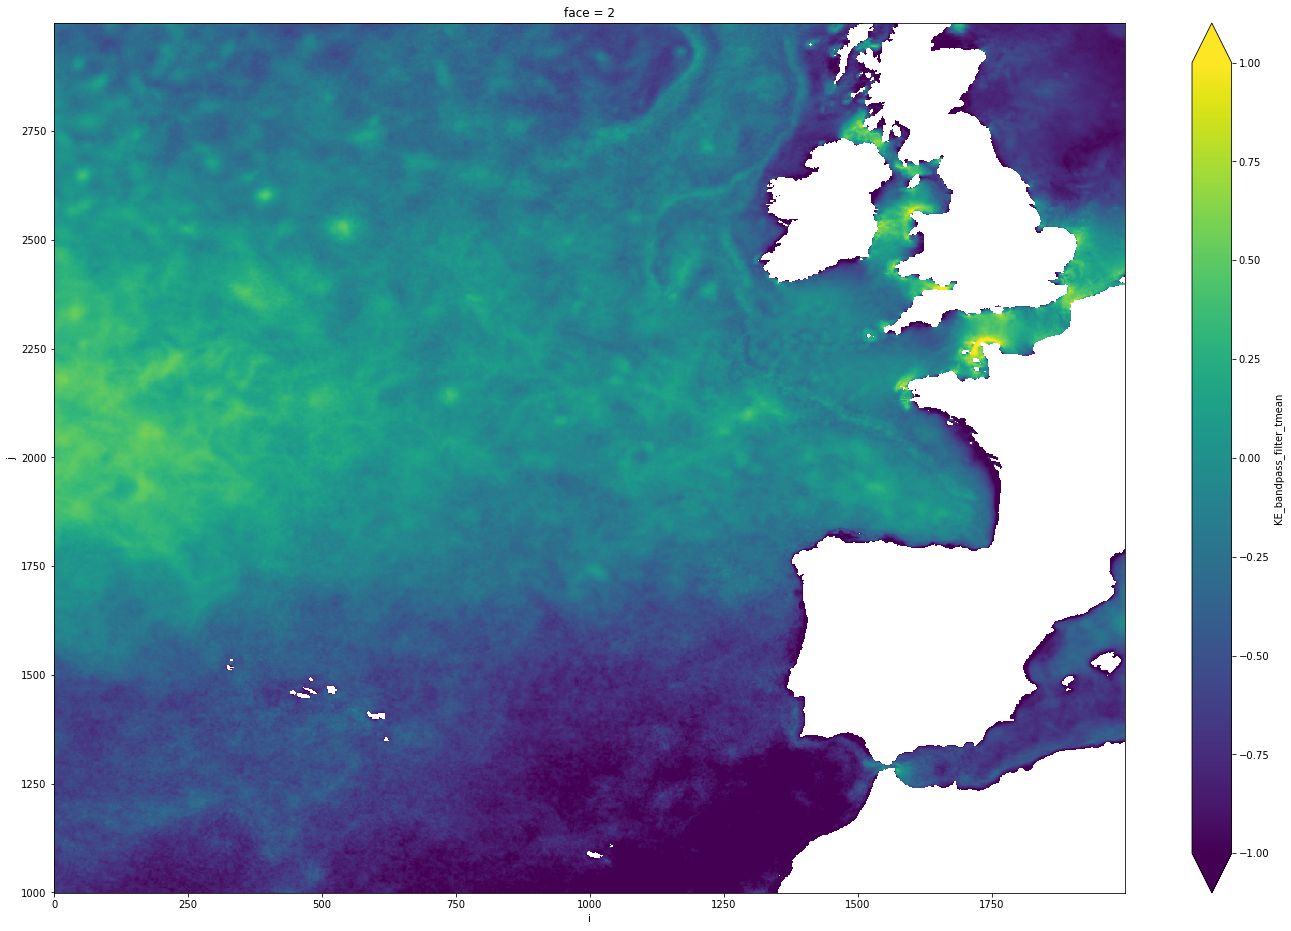

In [35]:
fig = plt.figure(figsize=(24,16))
np.log10(ds_KE.KE_bandpass_filter_tmean).isel(i=slice(0,1000),j=slice(500,1500)).plot(vmin=-1,vmax=1)

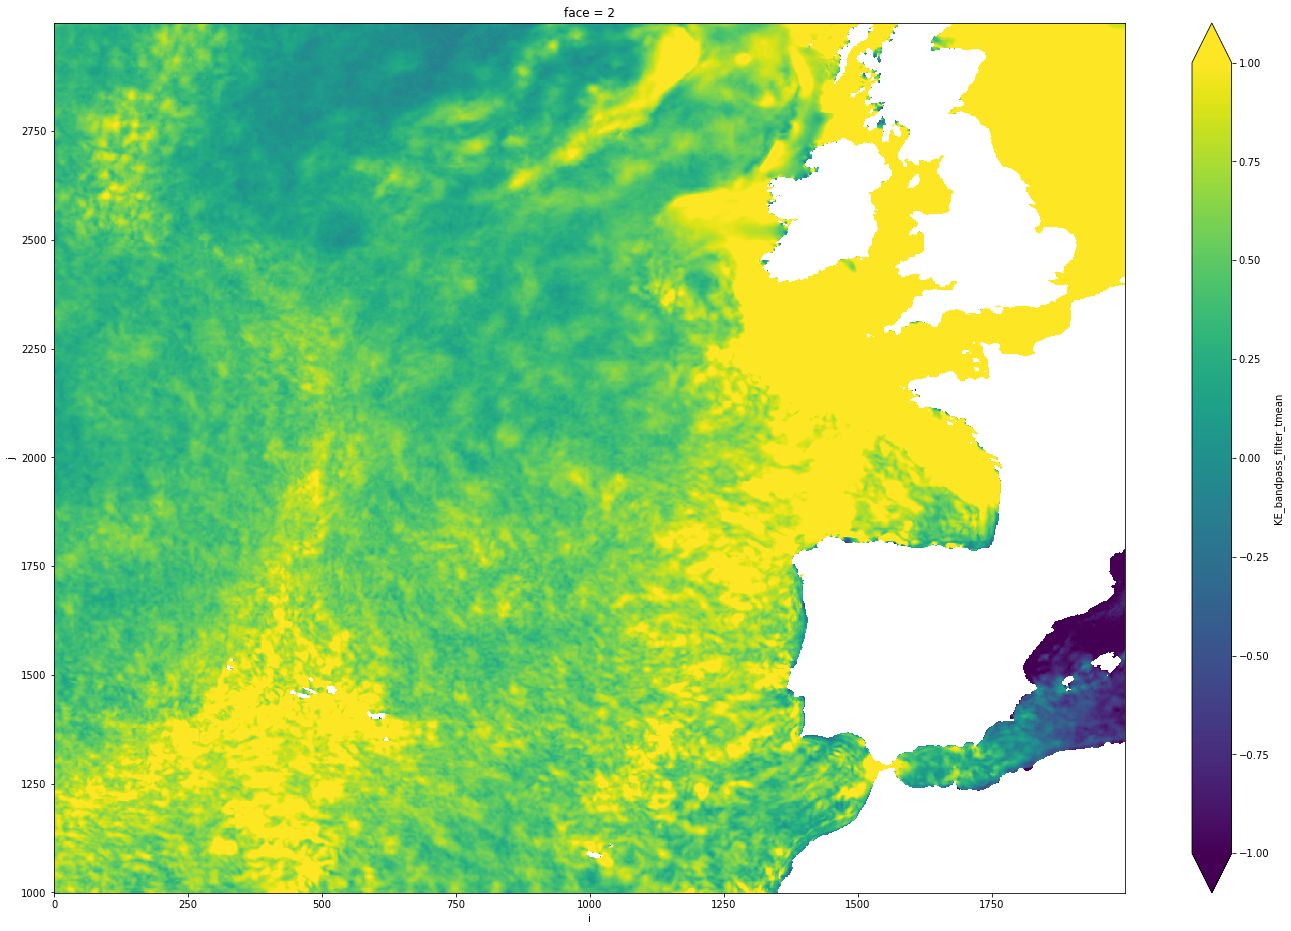

In [40]:
# Read KE
ds_m2 = xr.open_zarr(out_dir_zarr+'KE_m2_tmean.zarr')
fig = plt.figure(figsize=(24,16))
np.log10(ds_m2.KE_bandpass_filter_tmean).isel(i=slice(0,1000),j=slice(500,1500)).plot(vmin=-1,vmax=1)

In [41]:
cluster.close()